<a href="https://colab.research.google.com/github/taliarosenkranz/Marketing_Analysis_Forecasting/blob/main/Bancall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Goal of Analysis: How did past campaigns perform and what were the features that had major influences on the success of the campaigns. Can these features also forcast the likelyhood of success per customer, for a current campaign? We will be looking at the distribution of the data, how the features correlate with our target variable and train a binary classification machine learning model for predicting a campaigns success or failure for a given customer.

There seem to be a lot of null values in the poutcome column. this is because there is currently a campaign running and in which these customers are involved in. the pday feature shows -1 for all of the clients that have nan as poutcome, as they are new clients and have not been contacted before. When analyzing the performance of previous campaigns, we are excluding new clients.

# Libraries

In [198]:
# To handle the data
import pandas as pd
import numpy as np
import random

# To visualize the data
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# To preprocess the data and divide the data
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score,recall_score, classification_report, confusion_matrix

# Machine learning model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


# ignore warnings
import warnings
warnings.filterwarnings('ignore')


# Importing the dataset

In [199]:
!pip install ucimlrepo

In [200]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
X = bank_marketing.data.features
y = bank_marketing.data.targets

# metadata
print(bank_marketing.metadata)

# variable information
print(bank_marketing.variables)

{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'title': 'A data-driven approach to predict the success of bank telemarketing'

# Data inspection

In [201]:
print("X table shape is:", X.shape)
print("y table shape is:", y.shape)

X table shape is: (45211, 16)
y table shape is: (45211, 1)


In [202]:
X

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,NaN
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,NaN
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,NaN


In [203]:
y

,y
0,no
1,no
2,no
3,no
4,no
...,...
45206,yes
45207,yes
45208,yes
45209,no


In [204]:
X.isnull().sum()

age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
dtype: int64

In [205]:
y.isnull().sum()

y    0
dtype: int64

# Data manipulation

In [206]:
df_ = X.merge(y, how='inner', left_index=True, right_index=True)

In [207]:
df = df_.copy()
df.shape

(45211, 17)

In [208]:
# Converting month to numerical values
df['month'] = df['month'].replace({'may': '05', 'jun': '06', 'jul': '07', 'aug': '08', 'oct': '10', 'nov': '11', 'dec': '12', 'jan': '01', 'feb': '02', 'mar': '03', 'apr': '04', 'sep': '09'})


In [209]:
# Adding a year column so we can identify the day for each value
df['year']=pd.NA
fill_values = {idx: 2008 if idx < 27728 else (2009 if idx < 42591 else 2010) for idx in df.index}
df['year'] = df['year'].fillna(fill_values)

In [210]:
df=df.rename(columns={'day_of_week':'day'})

In [211]:
# Create the data column
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

In [212]:
# From the data source we know the calls registry are from these dates
date_range = pd.date_range(start='2008-05-05', end='2010-11-11')

# Create a DataFrame with the date range
date_df = pd.DataFrame({'date': date_range})

# Get the day of the week for each date
date_df['day_of_week'] = date_df['date'].dt.day_name()


# Merge the two DataFrames on the 'date' column
df = df.merge(date_df[['date', 'day_of_week']], on='date', how='left')

# Check if the merge was successful
print(df.head())

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married        NaN      no     1506     yes   no   
4   33           NaN   single        NaN      no        1      no   no   

  contact  day month  duration  campaign  pdays  previous poutcome   y  year  \
0     NaN    5    05       261         1     -1         0      NaN  no  2008   
1     NaN    5    05       151         1     -1         0      NaN  no  2008   
2     NaN    5    05        76         1     -1         0      NaN  no  2008   
3     NaN    5    05        92         1     -1         0      NaN  no  2008   
4     NaN    5    05       198         1     -1         0      NaN  no  2008   

        date day_of_week  
0 2008-05-05      Monday  
1 2008-05-05      Mo

# Missing values

In [213]:
#replacing missing values
df['job'].fillna('unknown', inplace=True)
df['education'].fillna('unknown', inplace=True)
df['contact'].fillna('unknown', inplace=True)
df['poutcome'].fillna('ongoing', inplace=True)

# Dealing with Outliers

In [214]:
# Droping lines where duration = 0 as they are outliers
print(df[df["duration"]==0])
df = df[df['duration'] != 0]

       age           job  marital  education default  balance housing loan  \
6424    53    management  married    primary      no      351     yes   no   
22937   35    technician  married  secondary      no     5535      no   no   
36425   31  entrepreneur  married  secondary      no      162     yes  yes   

        contact  day month  duration  campaign  pdays  previous poutcome   y  \
6424    unknown   27    05         0         4     -1         0  ongoing  no   
22937  cellular   26    08         0        15     -1         0  ongoing  no   
36425  cellular   11    05         0         2     -1         0  ongoing  no   

       year       date day_of_week  
6424   2008 2008-05-27     Tuesday  
22937  2008 2008-08-26     Tuesday  
36425  2009 2009-05-11      Monday  


In [215]:
# Droping lines where duration = 2 as they are outliers
print(df[df["duration"]==2])
df = df[df['duration'] != 2]

       age          job   marital  education default  balance housing loan  \
287     50   technician    single   tertiary      no      339     yes   no   
24994   36  blue-collar   married    primary      no      871     yes  yes   
30278   54   unemployed  divorced  secondary      no      925      no   no   

         contact  day month  duration  campaign  pdays  previous poutcome   y  \
287      unknown    5    05         2         3     -1         0  ongoing  no   
24994  telephone   18    11         2         1     -1         0  ongoing  no   
30278   cellular    5    02         2         1     -1         0  ongoing  no   

       year       date day_of_week  
287    2008 2008-05-05      Monday  
24994  2008 2008-11-18     Tuesday  
30278  2009 2009-02-05    Thursday  


In [216]:
# Generate a list of random colors
num_plots = 5  # Number of box plots
random_colors = [f'#{random.randint(0, 0xFFFFFF):06x}' for _ in range(num_plots)]

# Excluding new user where pdays = -1
new_user = df[df['pdays']!=-1]

plt.figure(figsize=(20, 20))

# make box plots for numeric columns

fig1 = px.box(data_frame=new_user, y='balance', color_discrete_sequence=[random_colors[0]], title="Balance Distribution")
fig2 = px.box(data_frame=new_user, y='duration', color_discrete_sequence=[random_colors[1]], title="Duration Distribution")
fig3 = px.box(data_frame=new_user, y='campaign', color_discrete_sequence=[random_colors[2]], title="Campaign Distribution")
fig4 = px.box(data_frame=new_user, y='pdays', color_discrete_sequence=[random_colors[3]], title="Previous Days Distribution")
fig5 = px.box(data_frame=new_user, y='previous', color_discrete_sequence=[random_colors[4]], title="Previous Distribution")
plt.tight_layout()

# Create subplots
fig = make_subplots(rows=3, cols=2, subplot_titles=("Average Yearly Balance Distribution", "Call Duration Distribution (sec)",
                                                    "#Calls in this Campaign", "Last call (days)",
                                                    "Number of contacts (#calls)"))

# Add box plots to subplots
fig.add_trace(fig1['data'][0], row=1, col=1)
fig.add_trace(fig2['data'][0], row=1, col=2)
fig.add_trace(fig3['data'][0], row=2, col=1)
fig.add_trace(fig4['data'][0], row=2, col=2)
fig.add_trace(fig5['data'][0], row=3, col=1)

# Update layout
fig.update_layout(height=800, showlegend=False)

# Show the subplot
fig.show()

<Figure size 2000x2000 with 0 Axes>

In [217]:
#creating function to filter outliers by inputed columns
def minmax_outlier_detection(data):
    # Filter the DataFrame to include only rows where the specified column is not equal to the specified value
    filtered_data = df[df['pdays'] != -1]

    # Calculate Q1 and Q3
    Q1 = filtered_data[data].quantile(0.25)
    Q3 = filtered_data[data].quantile(0.75)

    # Calculate IQR
    IQR = Q3 - Q1

    # Define lower and upper fences
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR

    # Create a boolean mask to identify rows without outliers
    mask = ~((df[data] < lower_fence) | (df[data] > upper_fence))

    # Return the boolean mask
    return mask

# Apply outlier detection to each column and update df
mask_balance = minmax_outlier_detection('balance')
mask_previous = minmax_outlier_detection('previous')
mask_pdays = minmax_outlier_detection('pdays')
mask_campaign = minmax_outlier_detection('campaign')
mask_duration = minmax_outlier_detection('duration')

# Combine masks to identify rows without outliers in any column
combined_mask = mask_balance & mask_previous & mask_pdays & mask_campaign & mask_duration

# Filter df to keep rows without outliers
df = df[combined_mask]

df.shape



(29890, 20)

Before cleaning the outliers in the dataset there were 45211 values, now we have 29890 remaining.

In [218]:
# Generate a list of random colors
num_plots = 5  # Number of box plots
random_colors = [f'#{random.randint(0, 0xFFFFFF):06x}' for _ in range(num_plots)]

plt.figure(figsize=(20, 20))

# Excluding new users so to see well distribution
filtered_data = df[df['pdays'] != -1]

# make box plots for numeric columns

fig1 = px.box(data_frame=filtered_data, y='balance', color_discrete_sequence=[random_colors[0]], title="Balance Distribution")
fig2 = px.box(data_frame=filtered_data, y='duration', color_discrete_sequence=[random_colors[1]], title="Duration Distribution")
fig3 = px.box(data_frame=filtered_data, y='campaign', color_discrete_sequence=[random_colors[2]], title="Campaign Distribution")
fig4 = px.box(data_frame=filtered_data, y='pdays', color_discrete_sequence=[random_colors[3]], title="Previous Days Distribution")
fig5 = px.box(data_frame=filtered_data, y='previous', color_discrete_sequence=[random_colors[4]], title="Previous Distribution")
plt.tight_layout()

# Create subplots
fig = make_subplots(rows=3, cols=2, subplot_titles=("Average Yearly Balance Distribution", "Call Duration Distribution (sec)",
                                                    "#Calls in this Campaign", "Last call (days)",
                                                    "Number of contacts (#calls)"))

# Add box plots to subplots
fig.add_trace(fig1['data'][0], row=1, col=1)
fig.add_trace(fig2['data'][0], row=1, col=2)
fig.add_trace(fig3['data'][0], row=2, col=1)
fig.add_trace(fig4['data'][0], row=2, col=2)
fig.add_trace(fig5['data'][0], row=3, col=1)

# Update layout
fig.update_layout(height=800, showlegend=False)

# Show the subplot
fig.show()

<Figure size 2000x2000 with 0 Axes>

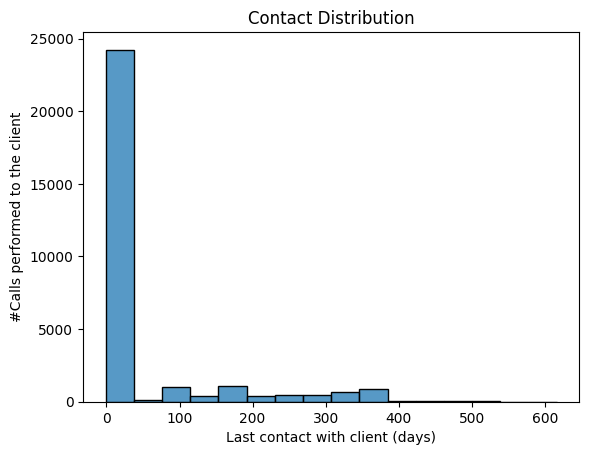

In [219]:
sns.histplot(data=df, x='pdays')
plt.xlabel('Last contact with client (days)')
plt.ylabel('#Calls performed to the client')
plt.title('Contact Distribution')
plt.show()

Most of the calls we have in our dataset are for new clients (pdays = -1)

# Data Exploration/Distribution

Demographic analysis

Mean: 40
Mode: 0    32
Name: age, dtype: int64


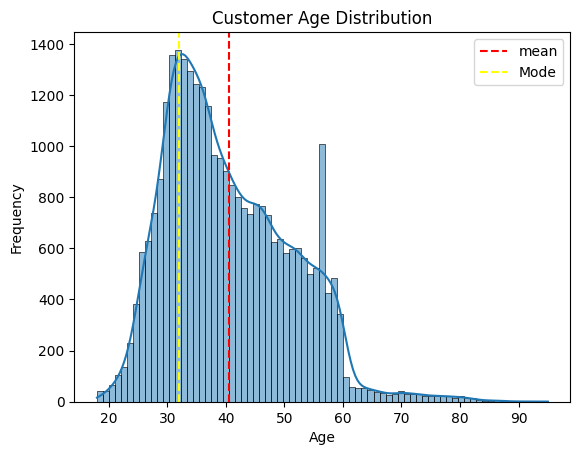

In [220]:
sns.histplot(df['age'],kde=True)
plt.axvline(df['age'].mean(), color='red', linestyle='--', label='mean')
plt.axvline(df['age'].mode().iloc[0], color='yellow', linestyle='--', label='Mode')
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Customer Age Distribution")
plt.legend()

print('Mean:', int(df['age'].mean()))
print('Mode:', df['age'].mode())

plt.show()

Most of the values inside the dataset are distributed between the ages of 30 and 40, then there's a decreese for the following ages.

The mean age is 40 and the mode 32.

In [221]:
job_count = df.job.value_counts()
job_count

job
blue-collar      6540
management       5907
technician       4936
admin.           3693
services         2856
retired          1488
entrepreneur      977
self-employed     973
unemployed        871
housemaid         794
student           682
unknown           173
Name: count, dtype: int64

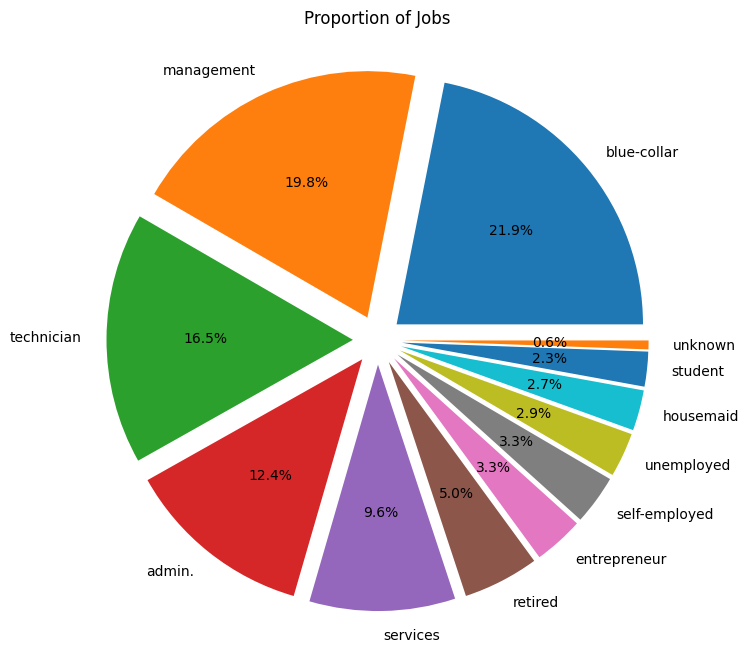

In [222]:
fig, ax = plt.subplots(figsize=(8,8))
explode = [0.1] * len(df['job'].value_counts())
ax.pie(df['job'].value_counts(), labels=df['job'].value_counts().index, autopct='%1.1f%%', explode = explode)
ax.set_title('Proportion of Jobs')
plt.show()

The bisgest percentage of values in the dataset belongs to people that works as blue collars followed by management area, technicians and so.

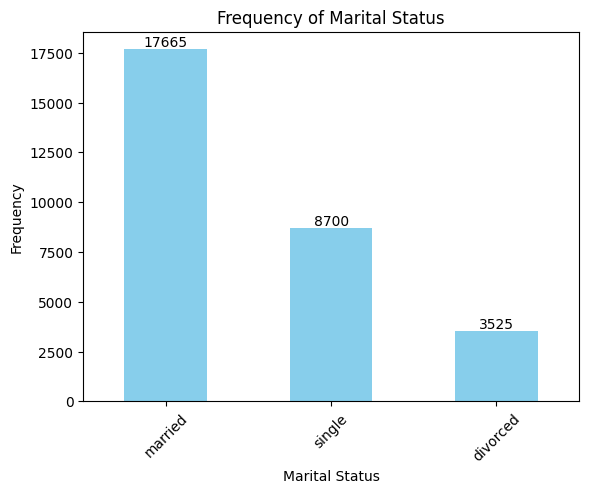

In [223]:
# Create a bar plot
ax = df['marital'].value_counts().plot(kind='bar', color='skyblue')

# Add data labels to each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# Add titles and labels
plt.title('Frequency of Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Show the plot
plt.show()


Most of the values in the dataset are married

# Previous Campaign Analysis

In [224]:
# Grouping values by different features
demo_seg = df.groupby(["age", "job", "marital","poutcome"])["duration"].mean().reset_index(name="duration_mean")

# Filtering "others" values so to evaluate the poutcome from previous campaigns
demo_seg_no_other = demo_seg[(demo_seg["poutcome"]!="other")&(demo_seg["poutcome"]!="ongoing")]

Undersampling the data so to be balanced and to evaluate the poutcome from prevous campaings

In [225]:
demo_seg_no_other

,age,job,marital,poutcome,duration_mean
2,18,student,single,success,151.000000
3,19,student,single,failure,158.333333
6,19,student,single,success,188.400000
11,20,student,married,failure,385.000000
13,20,student,single,failure,275.250000
...,...,...,...,...,...
2962,82,retired,married,success,275.000000
2965,83,retired,married,failure,201.000000
2967,84,retired,divorced,failure,145.000000
2974,86,retired,married,success,219.500000


In [226]:
fig = px.scatter(demo_seg_no_other, x="age", y="duration_mean", color="poutcome",
                 title="Distribution of Call Duration by Age",
                 labels={"age": "Age", "duration_mean": "Call Duration (sec)","job":"Job"},
                 hover_name="marital")

fig.update_layout(xaxis_title="Age", yaxis_title="Call Duration (sec)")

fig.show()

For the segmented group selected, it is evident that the majority of failures occur in calls with a duration with less than  5 minutes.

However, for individuals aged over 60, the majority of outcomes are successes.

Additionally, there is a higher likelihood of success for calls with an average duration greater than 5 minutes, as indicated by the plot

Success:
  *Mean: 43.7  *Mode: 38
Failure:
  *Mean: 43.17  *Mode: 40


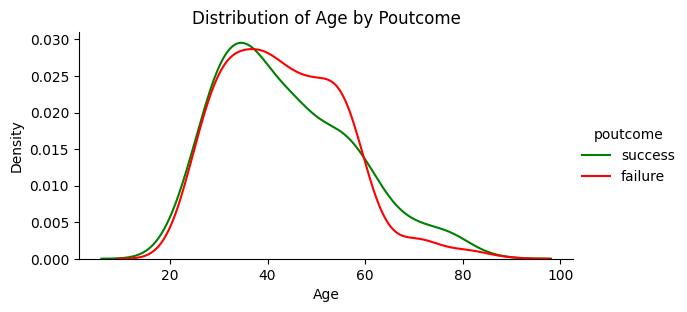

In [227]:
colors = {'success': 'green', 'failure': 'red'}
g = sns.FacetGrid(demo_seg_no_other, hue="poutcome", palette=colors, aspect=2)

g.map(sns.distplot, 'age', hist=False)
g.add_legend()

plt.title('Distribution of Age by Poutcome')
plt.xlabel('Age')
plt.ylabel('Density')

print('Success:\n',' *Mean:',round(demo_seg_no_other['age'][demo_seg_no_other['poutcome']=='success'].mean(),2) ,' *Mode:',demo_seg_no_other['age'][demo_seg_no_other['poutcome']=='success'].mode().iloc[0]  )
print('Failure:\n',' *Mean:',round(demo_seg_no_other['age'][demo_seg_no_other['poutcome']=='failure'].mean(),2) ,' *Mode:',demo_seg_no_other['age'][demo_seg_no_other['poutcome']=='failure'].mode().iloc[0]  )

plt.show()

Building on the previous conclusion, we can identify a specific area for potential improvement within the segmented values:

* Particularly among individuals with more than 60. This age group exhibits a notable proportion of success, suggesting an opportunity for the company to focus its efforts on refining its strategies or tailoring its offerings to better engage and convert customers within this demographic.

* It's also possible to note customers close to the age of 38 are more likely to accept a loan.

* From age 40 till 60 there're higher chances that the customer wont accept a loan.

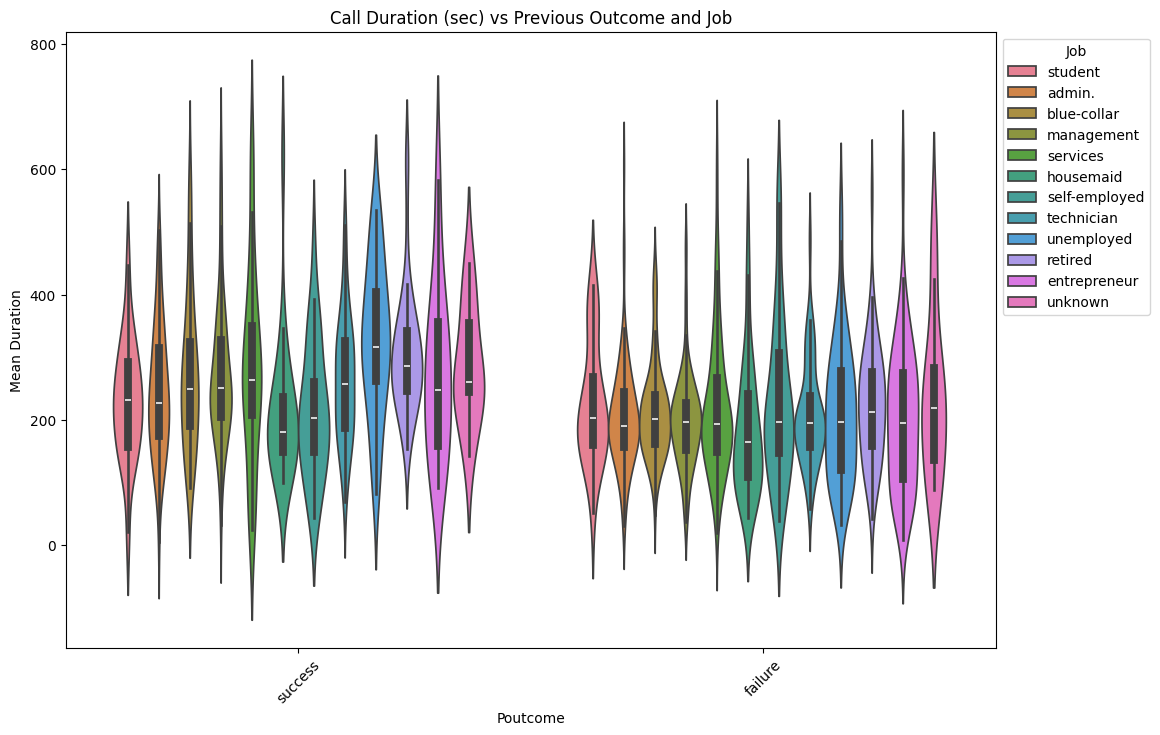

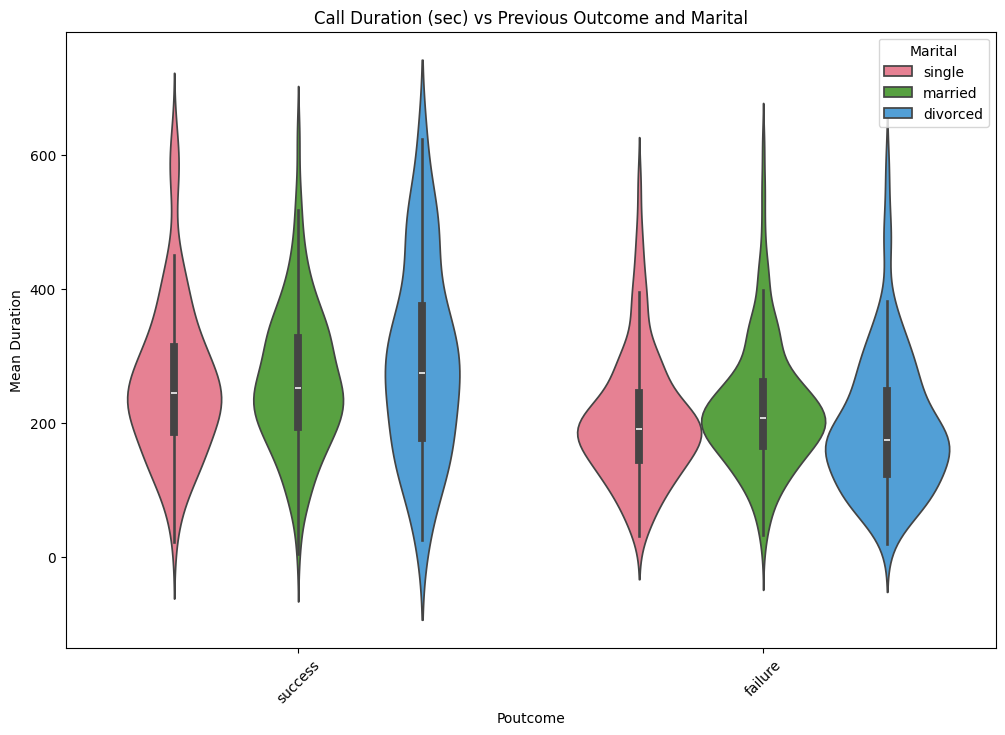

In [228]:
columns = ['job', 'marital']

for i in columns:
  plt.figure(figsize=(12, 8))
  sns.violinplot(data=demo_seg_no_other, x='poutcome', y='duration_mean', hue=i, dodge=True, palette='husl')

  plt.title('Call Duration (sec) vs Previous Outcome and ' + i.title())
  plt.xlabel('Poutcome')
  plt.ylabel('Mean Duration')
  plt.legend(title= i.title() , bbox_to_anchor=(1, 1))
  plt.xticks(rotation=45)
  plt.show()


For both features, we observe that successful outcomes from previous campaigns exhibit a higher density for average call durations exceeding 3 minutes (200 sec). This suggests that longer call durations may be associated with higher success rates, indicating a potential area of focus for future campaigns.

In [229]:
df_corr = df.copy()
# Selecting columns that will not be used
df_corr = df_corr.drop(columns=['contact','y','day', 'month','year', 'date', 'day_of_week'])
# Only using values from previous campaign
df_corr= df_corr[(df_corr['poutcome']!='other')&(df_corr['poutcome']!='ongoing')]
# Encode categorical columns using LabelEncoder
categorical_cols = ["job", "marital", "education", "default", "housing", "loan",'poutcome']
label_encoder = LabelEncoder()
for col in categorical_cols:
    df_corr[col] = label_encoder.fit_transform(df_corr[col])

df_corr

,age,job,marital,education,default,balance,housing,loan,duration,campaign,pdays,previous,poutcome
24060,33,0,1,2,0,882,0,0,39,1,151,3,0
24064,33,7,1,1,0,3444,1,0,144,1,91,4,0
24077,36,4,1,2,0,0,1,0,140,1,143,3,0
24080,56,9,1,1,0,589,1,0,518,1,147,2,1
24127,51,0,2,1,0,3132,0,0,449,1,176,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45193,28,6,2,2,0,159,0,0,449,2,33,4,1
45194,59,4,1,2,0,138,1,1,162,2,187,5,0
45195,68,5,1,1,0,1146,0,0,212,1,187,6,1
45201,53,4,1,2,0,583,0,0,226,1,184,4,1


**Timeline outcome analysis**

In [230]:
df_campaign = df.copy()
df_campaign = df[(df["poutcome"] != "other") & (df["poutcome"] != "ongoing")]

In [231]:
# Grouping by Day of the week and loan outcome
df_campaign_ = df_campaign.groupby(['day_of_week', 'poutcome'])['poutcome'].count().reset_index(name="outcome_count")

In [232]:
# Calculate conversion rate for each row
df_campaign_['conversion_rate'] = df_campaign_.apply(lambda row: row['outcome_count'] / df_campaign_[df_campaign_['day_of_week'] == row['day_of_week']]['outcome_count'].sum(), axis=1)
# Dropping Saturday and Sunday values as these are not working days (outliers)
df_campaign_ = df_campaign_[~((df_campaign_['day_of_week'] == 'Saturday') | (df_campaign_['day_of_week'] == 'Sunday'))]

In [233]:
# Define the custom order of days
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Convert the 'day_of_week' column to categorical with the custom order
df_campaign_['day_of_week'] = pd.Categorical(df_campaign_['day_of_week'], categories=days, ordered=True)

# Sort the DataFrame by the 'day_of_week' column
sorted_df_campaign = df_campaign_.sort_values(by='day_of_week')

# Display the sorted DataFrame
print(sorted_df_campaign)


   day_of_week poutcome  outcome_count  conversion_rate
2       Monday  failure            782         0.790698
3       Monday  success            207         0.209302
7      Tuesday  failure            591         0.737828
8      Tuesday  success            210         0.262172
9    Wednesday  failure            652         0.744292
10   Wednesday  success            224         0.255708
5     Thursday  failure            808         0.748148
6     Thursday  success            272         0.251852
0       Friday  failure            730         0.819304
1       Friday  success            161         0.180696


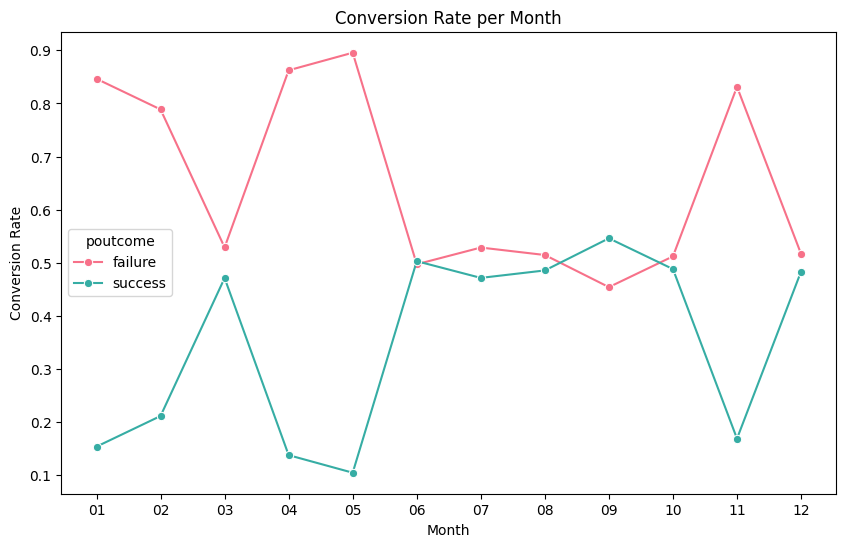

In [234]:
# Grouping by month
df_campaign_month = df_campaign.groupby(['month', 'poutcome'])['poutcome'].count().reset_index(name="outcome_count")
# Calculate conversion rate for each row
df_campaign_month['conversion_rate'] = df_campaign_month.apply(lambda row: row['outcome_count'] / df_campaign_month[df_campaign_month['month'] == row['month']]['outcome_count'].sum(), axis=1)

# Plot conversion rate per month
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_campaign_month, x='month', y='conversion_rate', hue='poutcome', marker='o', palette='husl')

# Set title, x-label, and y-label
plt.title('Conversion Rate per Month')
plt.xlabel('Month')
plt.ylabel('Conversion Rate')

# Show the plot
plt.show()

After analyzing the plot, it's evident that the most favorable months for customer acceptance of a loan are March, June, and particularly September, where we observe a higher conversion rate. Therefore, focusing efforts on contacting customers during these months may yield better outcomes.

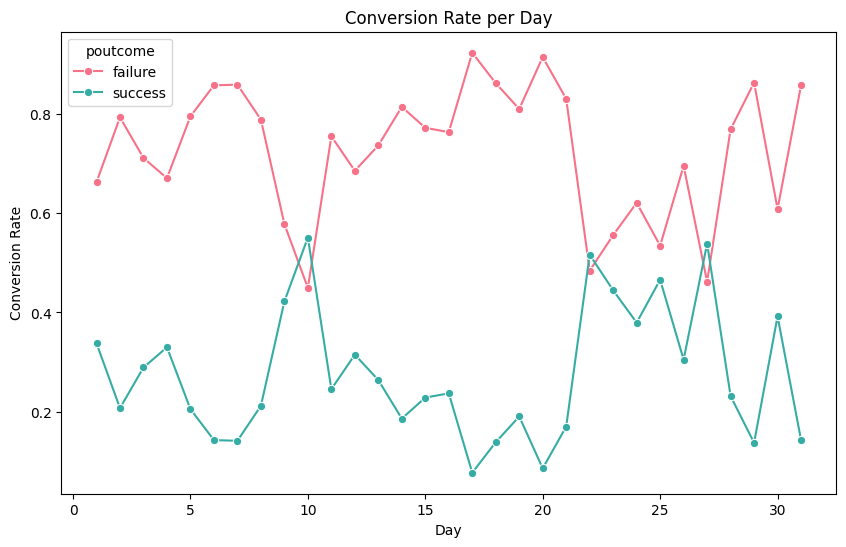

In [239]:
# Grouping by day
df_campaign_day = df_campaign.groupby(['day', 'poutcome'])['poutcome'].count().reset_index(name="outcome_count")
# Calculate conversion rate for each row
df_campaign_day['conversion_rate'] = df_campaign_day.apply(lambda row: row['outcome_count'] / df_campaign_day[df_campaign_day['day'] == row['day']]['outcome_count'].sum(), axis=1)

# Plot conversion rate per month
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_campaign_day, x='day', y='conversion_rate', hue='poutcome', marker='o', palette='husl')

# Set title, x-label, and y-label
plt.title('Conversion Rate per Day')
plt.xlabel('Day')
plt.ylabel('Conversion Rate')

# Show the plot
plt.show()

We can appreciate that by the end of the month is where the conversion rate of users accepting loans increase.

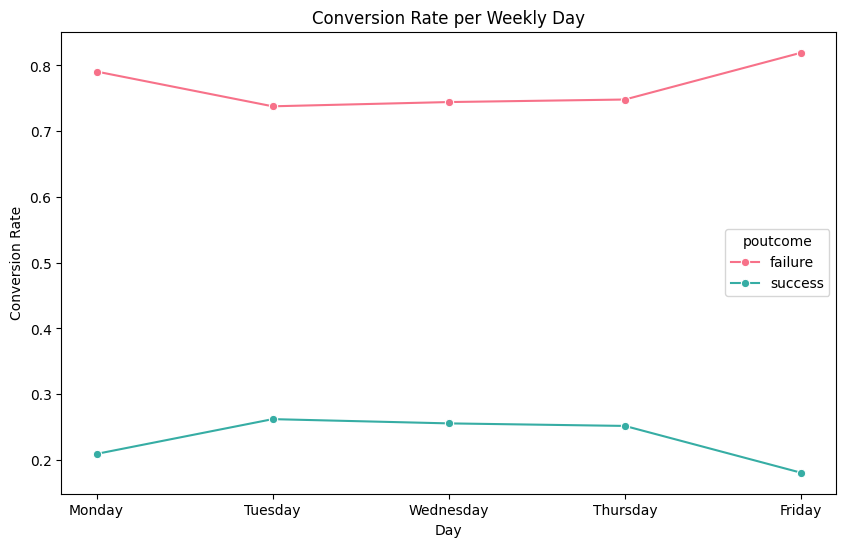

In [182]:
# Plot conversion rate against campaign
plt.figure(figsize=(10, 6))
sns.lineplot(x='day_of_week', y='conversion_rate', hue='poutcome', data=df_campaign_, marker='o', palette='husl')

# Set title, x-label, and y-label
plt.title('Conversion Rate per Weekly Day')
plt.xlabel('Day')
plt.ylabel('Conversion Rate')

# Show the plot
plt.show()

We can appreciate that the days with the highest success rate are Tuesdays, and Fridays are the ones with the less.

<Axes: >

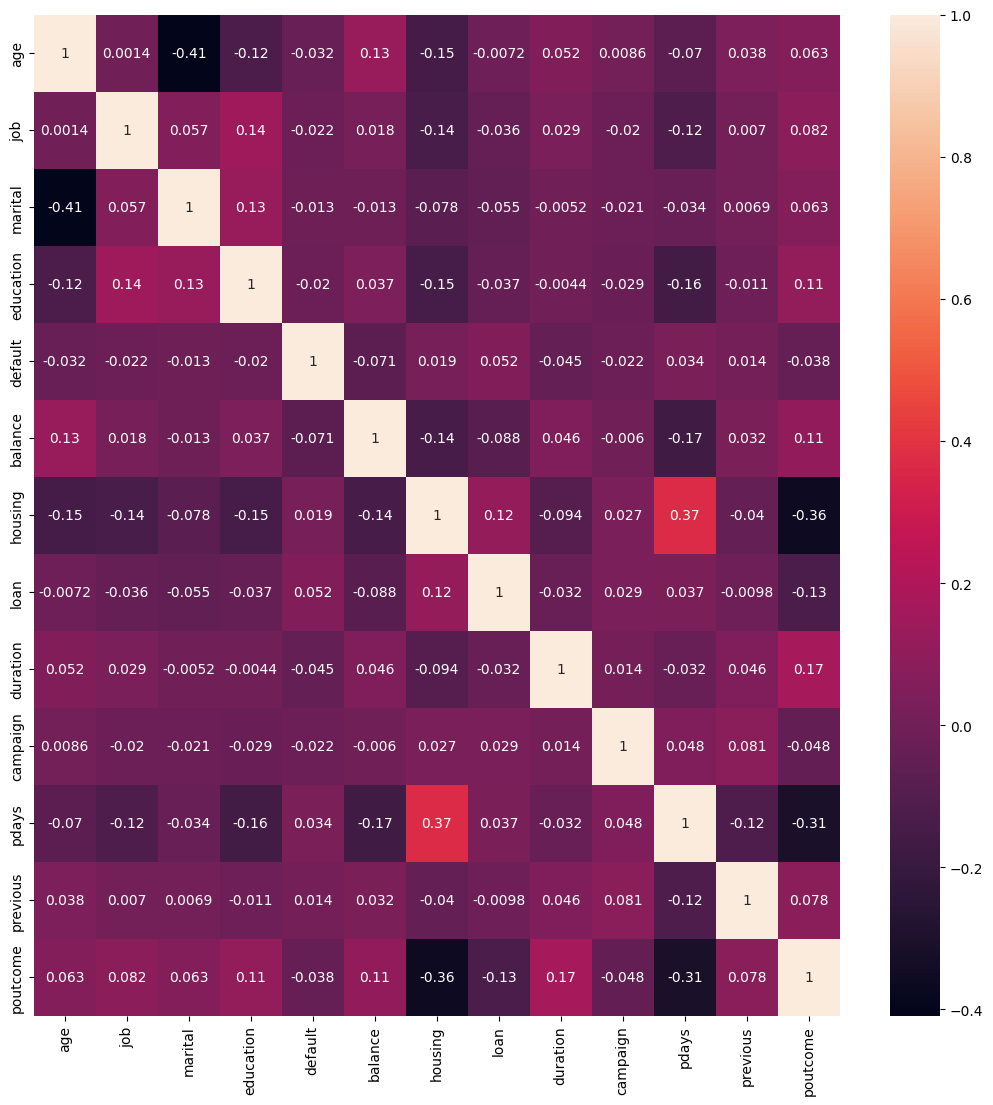

In [122]:
plt.figure(figsize=(13,13))
sns.heatmap(data=df_corr.corr(),annot=True )

There appears to be a noticeable correlation between the number of days pasted since the last calls made to a customer (pdays) a longer interval between calls (pdays) is associated with a higher risk of failure.

As for the call duration, there is also a correlation, we could appreciate before where longer duration calls has higher chances of succeding with the customer signing for a loan.

Furthermore, we can see a strong correlation between the housing and the outcome, where people who has a house loan are not agreeing for a new loan.
Something similar happen with those users who has a personal loan.



# Understanding response patterns to past marketing campaigns


In [187]:
#Number of successful campaigns
success_count = df[df["poutcome"] == "success"].shape[0]

#Total count excluding "unknown" values in "poutcome" column
total_count = df[df["poutcome"] != "ongoing"].shape[0]

#Calculating conversion rate
cr = (success_count / total_count) * 100
print(f"{round(cr, 2)}% of clients are considered a success for the marketing campaign.")

18.71% of clients are considered a success for the marketing campaign.


In [188]:
#group by campaign (number of times that client was called) and calculate the success rate. this way we can see if it makes sense to call more or less for higher chances of success.
df_campaign = df[(df["poutcome"] != "other") & (df["poutcome"] != "ongoing")]
df_campaign_ = df_campaign.groupby(['campaign', 'poutcome'])['poutcome'].count().reset_index(name="outcome_count")

# Calculate the mean duration for each campaign and poutcome combination
mean_duration = df_campaign.groupby(['campaign', 'poutcome'])['duration'].mean().reset_index(name='duration_mean')

# Merge the mean duration DataFrame with the df_campaign DataFrame
df_campaign = pd.merge(df_campaign_, mean_duration, on=['campaign', 'poutcome'])

In [189]:
# Calculate conversion rate for each row
df_campaign['conversion_rate'] = df_campaign.apply(lambda row: row['outcome_count'] / df_campaign[df_campaign['campaign'] == row['campaign']]['outcome_count'].sum(), axis=1)

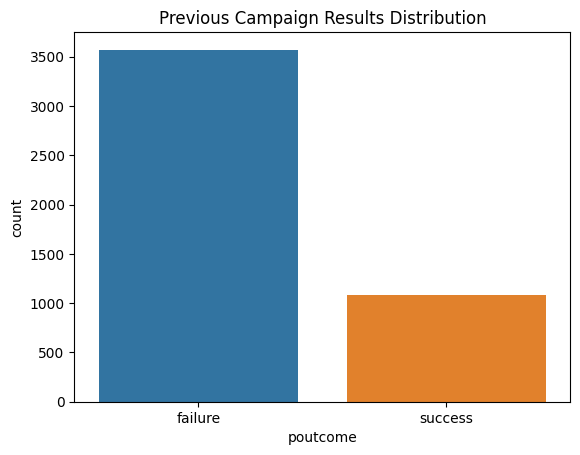

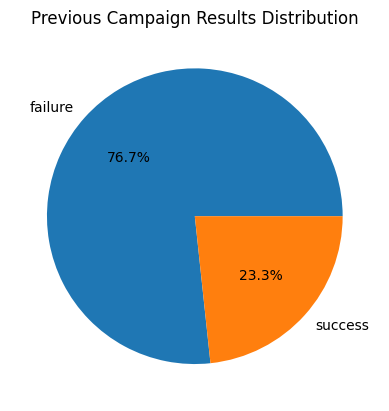

In [190]:
# Filter out 'ongoing' and 'other' values from 'poutcome' column
df_poutcome = df[(df['poutcome'] != 'ongoing') & (df['poutcome'] != 'other')]

# Create count plot
sns.countplot(data=df_poutcome, x='poutcome', hue=df_poutcome.poutcome)
plt.title('Previous Campaign Results Distribution')
plt.show()

# Create pie chart
plt.pie(df_poutcome['poutcome'].value_counts(), labels=df_poutcome['poutcome'].unique(), autopct='%1.1f%%')
plt.title('Previous Campaign Results Distribution')
plt.show()

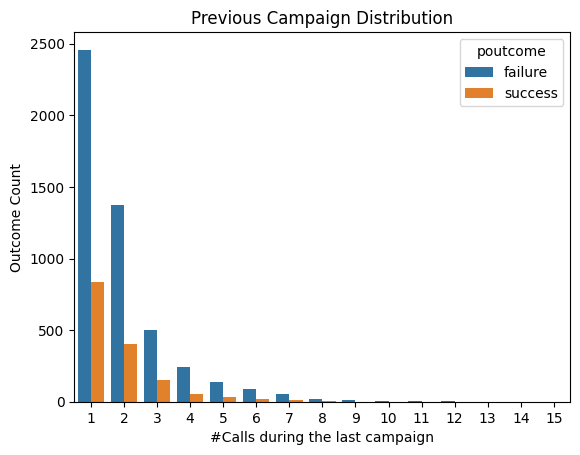

In [ ]:
sns.barplot(data=df_campaign, x='campaign', y='outcome_count', hue='poutcome')
plt.xlabel('#Calls during the last campaign')
plt.ylabel('Outcome Count')
plt.title('Previous Campaign Distribution')
plt.show()


The following graphs show the percentage of success and failure individual values from various features had in past marketing campaigns (poutcome). Important to keep in mind that correlation is not causation (ex: just because we see a high number of people that have never taken a loan, and were not successfully converted in the marketing campaign, does not mean that the cause for lack of success was the lack of a loan).

# Financial Segmentation Analysis

In [ ]:
def countplot_withY(label, dataset):
    dataset = dataset[(dataset["poutcome"] != "other") & (dataset["poutcome"] != "ongoing")]
    plt.figure(figsize=(20,10))
    Y = dataset[label]
    total = len(Y)*1.

    ax = sns.countplot(x=label, data=dataset, hue="poutcome")

    # Filter out bars with height equal to zero
    bars_to_keep = [bar for bar in ax.patches if bar.get_height() > 0]

    # Add value labels to each remaining bar
    for p in bars_to_keep:
      ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

    ax.yaxis.set_ticks(np.linspace(0, total, 11))
    ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.title(f'{label} ')

    plt.show()

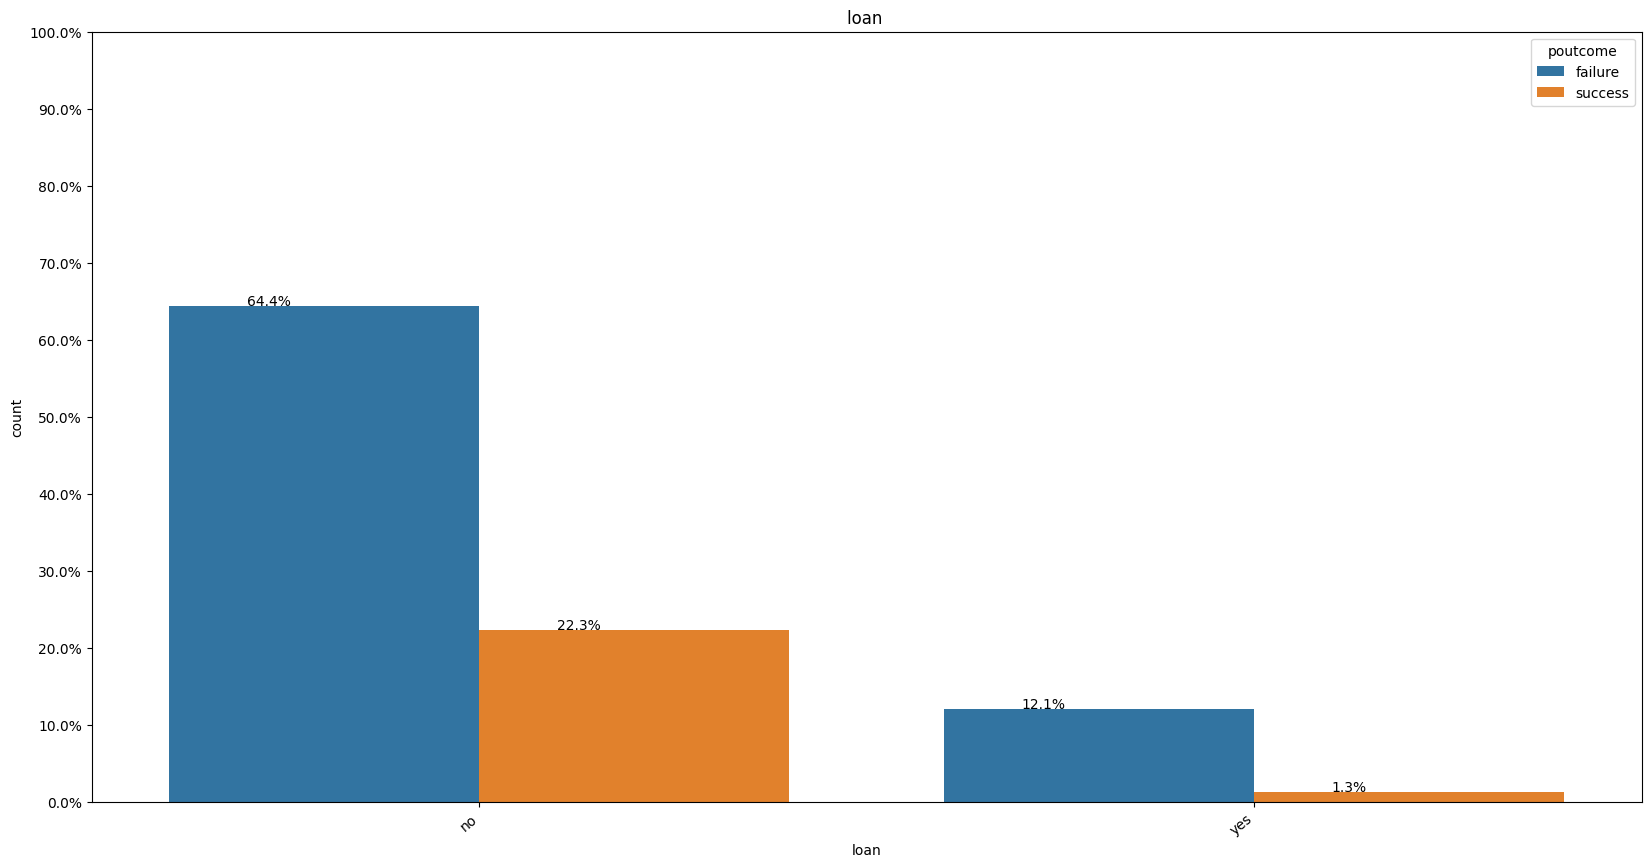

In [ ]:
countplot_withY('loan', df)

Those that have not had a loan in the past show a high percentage (64%) of failure to achieve historical marketing campaigns while only 1.3% of customers that have had a loan in the past werde successfully converted.

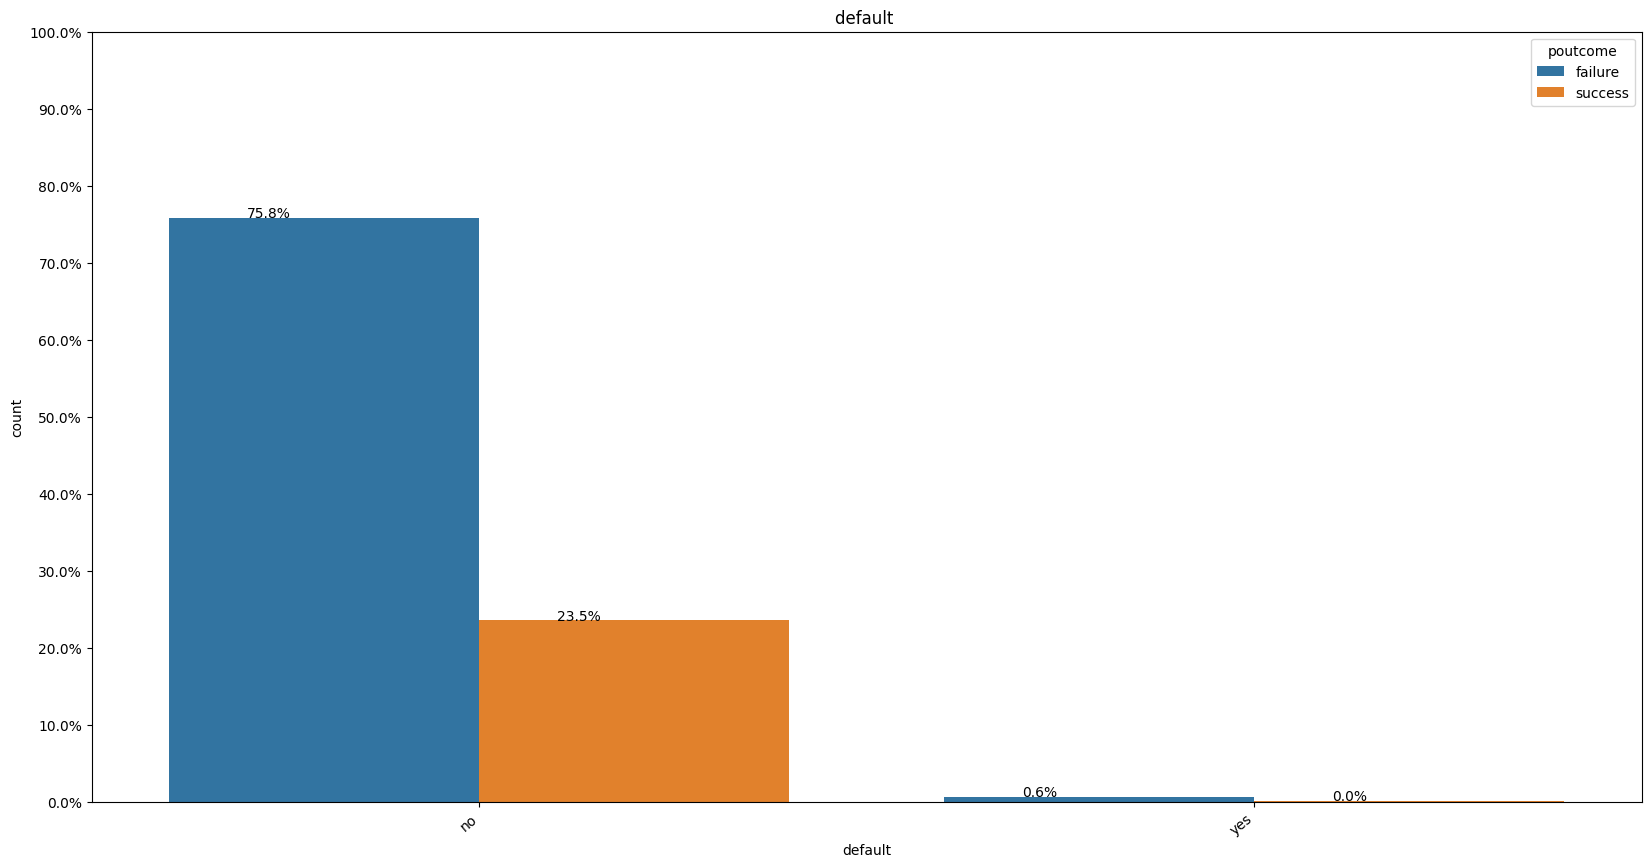

In [ ]:
countplot_withY('default', df)

In [ ]:
df[(df['default']=='yes')&(df['poutcome']=='success')]

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
26956,31,entrepreneur,single,tertiary,yes,-405,yes,yes,cellular,21,nov,846,1,100,2,success,no
28577,27,blue-collar,single,secondary,yes,81,no,yes,cellular,29,jan,123,2,205,2,success,no


If you ever had a default you are less likely to take a loan.
We can see in the above example, for the only 2 clients that were successful in the last campaign and previously defaulted on their loan, for the new one they decided not to take the loan ('y' = no)

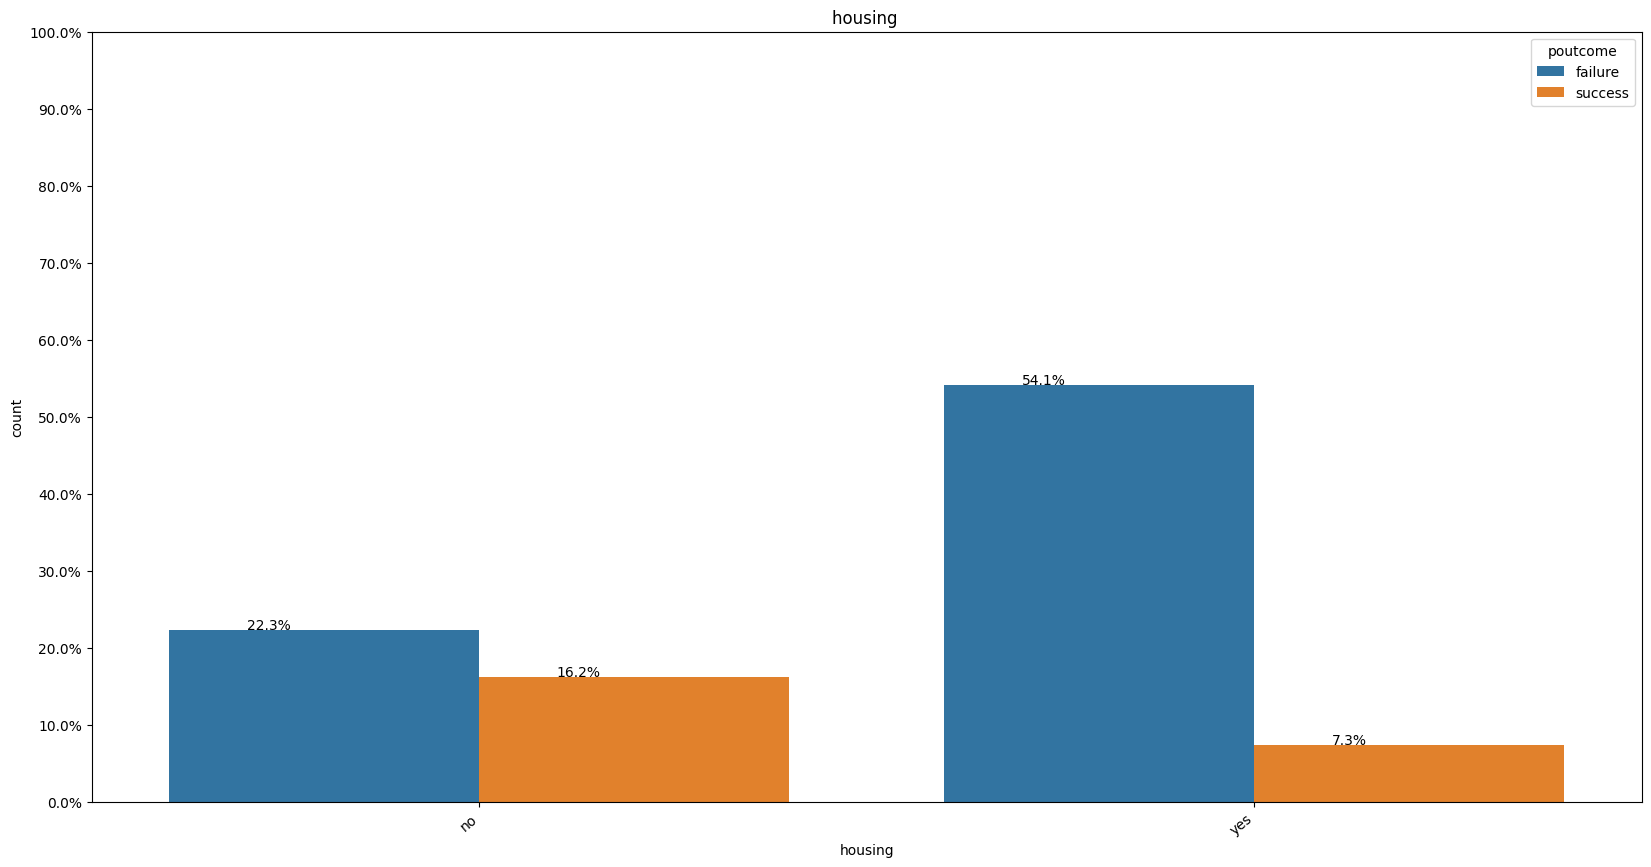

In [ ]:
countplot_withY('housing', df)

Most of the people who asked for a loan for their houses are not agreeing the new loan.

There is a good chance that if the client does not have a housing loan, they will accept for the loan.

Hi Gaby! ♥

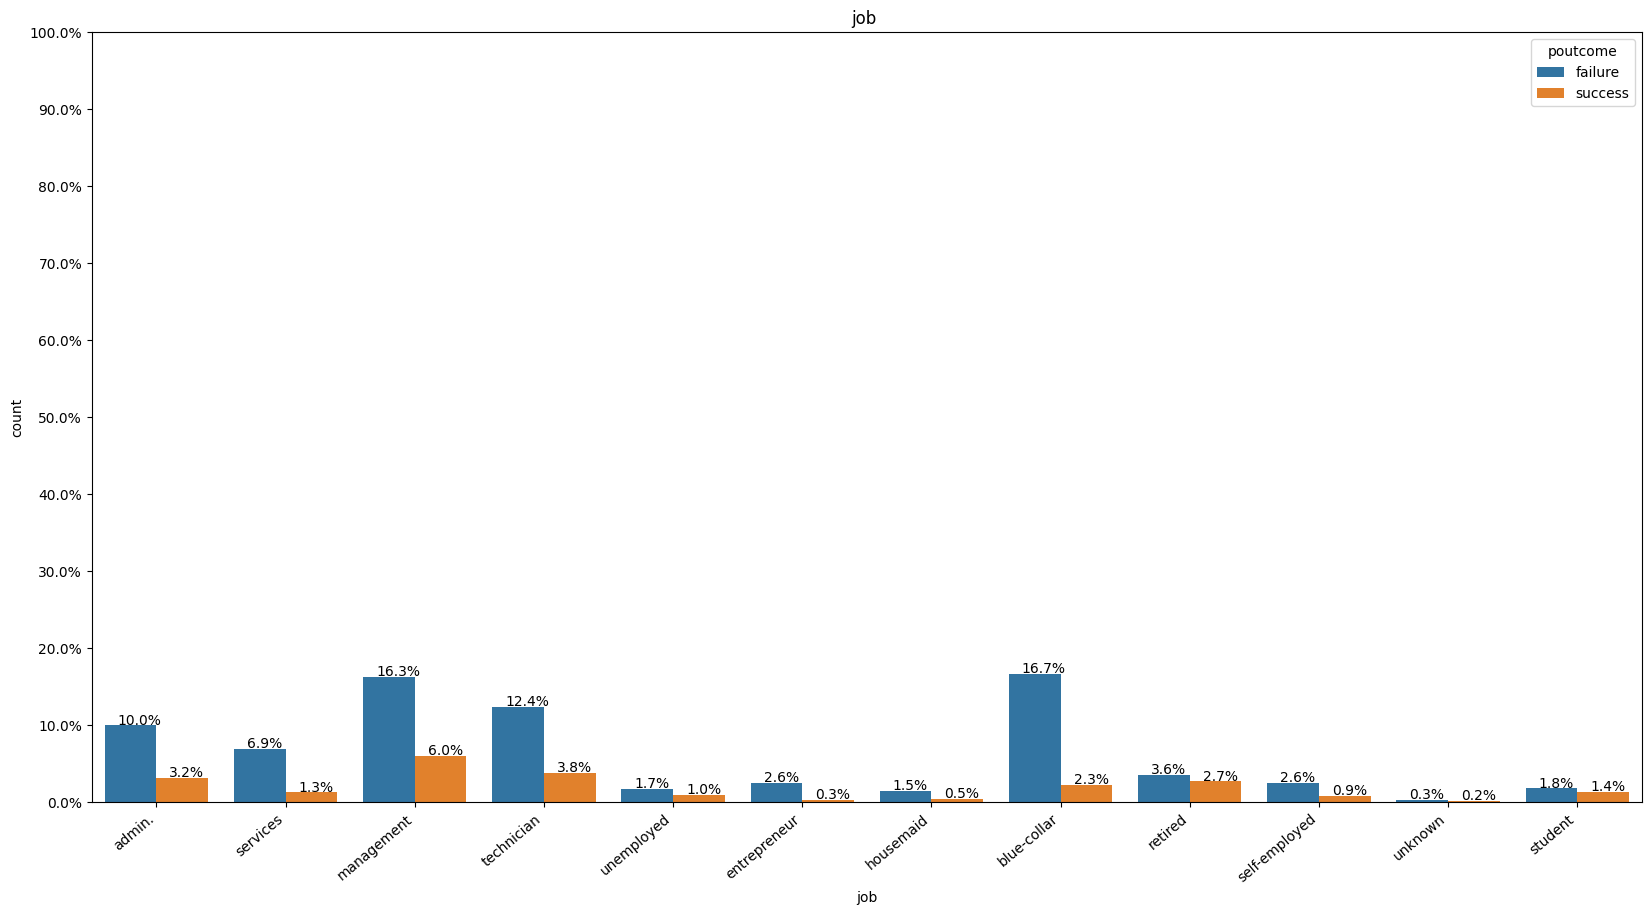

In [ ]:
countplot_withY("job", df)

Most successful past marketing campaigns were by customers working in management, as technicians, retired and blue-collar. However, these also had the highest rate of failure therefore not necessarily a good choice for investing into targeting these customers. Unemplyed, students and retired seem to have equal chances  in success and failure. There is not a singel job in which there were more successes than failres.

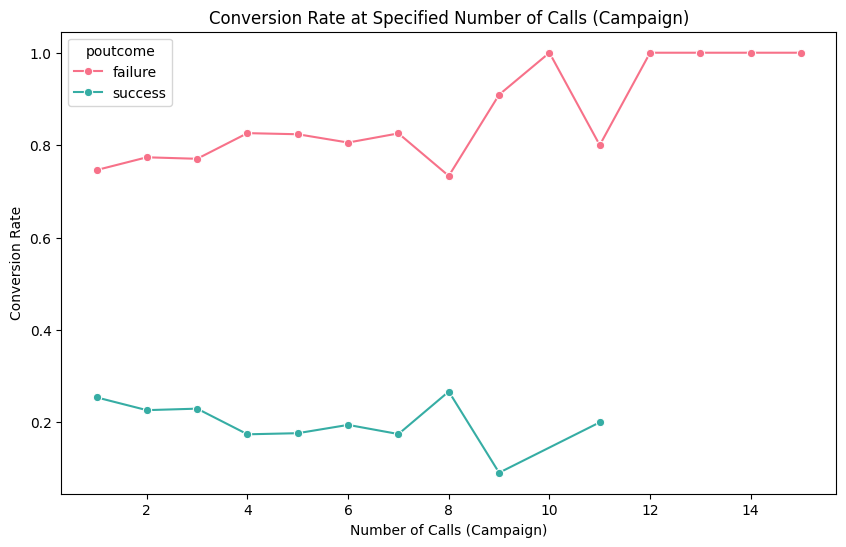

In [ ]:
# Plot conversion rate against campaign
plt.figure(figsize=(10, 6))
sns.lineplot( data=df_campaign,x='campaign', y='conversion_rate', hue='poutcome', marker='o', palette='husl')

# Set title, x-label, and y-label
plt.title('Conversion Rate at Specified Number of Calls (Campaign)')
plt.xlabel('Number of Calls (Campaign)')
plt.ylabel('Conversion Rate')

# Show the plot
plt.show()


At no point are the successes higher than the failure, however we do see that the highest success rate is at 8 calls. after that, the opportunity cost will not be worth it anymore as the chaces for failure are too high. Actually we see that from 11 calls onwards there are no successes at all anymore.

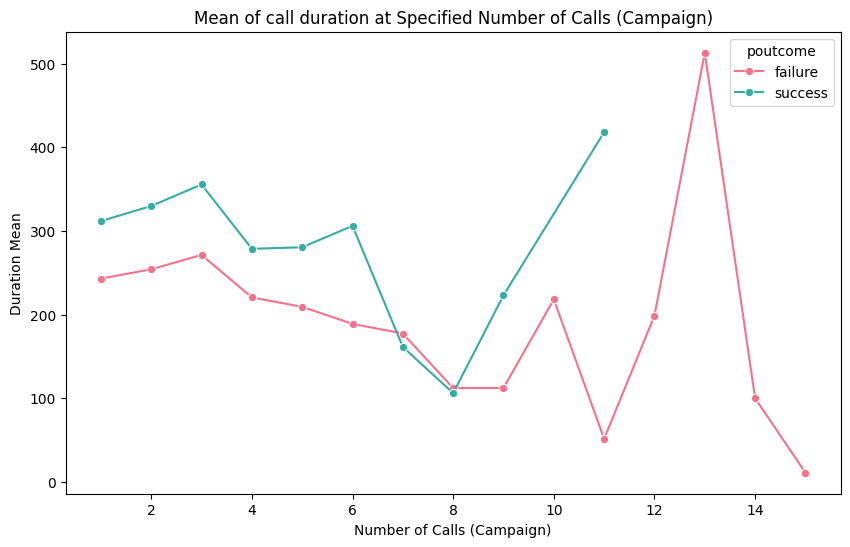

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='campaign', y='duration_mean', hue='poutcome', data=df_campaign, marker='o', palette='husl')

# Set title, x-label, and y-label
plt.title('Mean of call duration at Specified Number of Calls (Campaign)')
plt.xlabel('Number of Calls (Campaign)')
plt.ylabel('Duration Mean')

# Show the plot
plt.show()

Plotting the mean of each call duration by campaign (number of calls per person), we can infer that the chances for success are higher when the call is longer, within the first 6 calls. As we saw in the previous plot, a total of 8 calls has the highest conversion rate for success, however with short durations of that call. One reason for that could be that the deal is being closed in that call, and no more time is taken up by sales technique and convincing of the customer. Additionally, we can see that the mean duration strongly increases for any calls after the 8th. However from the 9th call on, these can be considered outliers, as the number of clients that have received this high number of calls are within the single digits.

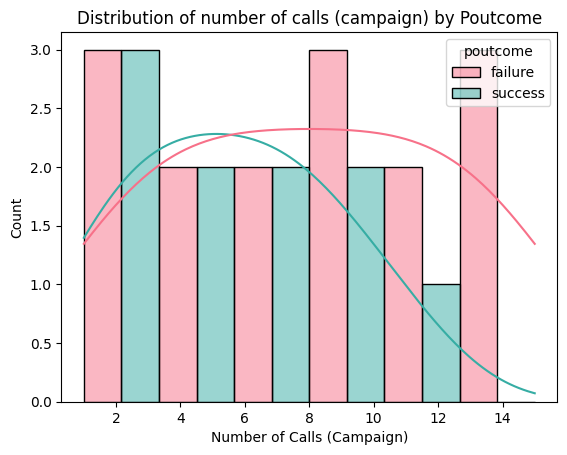

In [ ]:
g = sns.histplot(data= df_campaign, x='campaign', hue="poutcome", palette="husl",multiple='dodge',  kde=True )


# Set title, x-label, and y-label
plt.title('Distribution of number of calls (campaign) by Poutcome')
plt.xlabel('Number of Calls (Campaign)')
plt.ylabel('Count')

# Show the plot
plt.show()


We can appreciate in this plot that after the 5th call, there's a higher chance of failure in the deal.
The ideal number of calls lies between 2 to 6.

# Encoding categorical columns

In [ ]:
cat_cols= df.select_dtypes(include =[object])

In [ ]:
cat_cols

,job,marital,education,default,housing,loan,contact,month,poutcome,y
0,management,married,tertiary,no,yes,no,NaN,may,NaN,no
1,technician,single,secondary,no,yes,no,NaN,may,NaN,no
2,entrepreneur,married,secondary,no,yes,yes,NaN,may,NaN,no
3,blue-collar,married,NaN,no,yes,no,NaN,may,NaN,no
4,NaN,single,NaN,no,no,no,NaN,may,NaN,no
...,...,...,...,...,...,...,...,...,...,...
45206,technician,married,tertiary,no,no,no,cellular,nov,NaN,yes
45207,retired,divorced,primary,no,no,no,cellular,nov,NaN,yes
45208,retired,married,secondary,no,no,no,cellular,nov,success,yes
45209,blue-collar,married,secondary,no,no,no,telephone,nov,NaN,no


In [ ]:
df["y"].replace({"yes": True, "no": False}, inplace = True)

In [ ]:
df = pd.get_dummies(df)

In [ ]:
df.y.value_counts()

y
False    39922
True      5289
Name: count, dtype: int64

# Model Selection and Evaluation

In [ ]:
X = df.drop(["y", "duration"], axis = 1)
y = df['y']

# Split the data into Training and Testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Define the parameters for Decision Tree Classifier
dt_params = {'criterion': 'entropy',
             'max_depth': 10,
             'max_features': None,
             'min_samples_leaf': 4,
             'min_samples_split': 10}

# Define the Decision Tree Classifier with specified parameters
dt = DecisionTreeClassifier(**dt_params, random_state=0)

# Fitting the model to the training data
dt.fit(X_train, y_train)

# Predict using the trained model
y_pred_dt = dt.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print("F1-score:", f1_score(y_test, y_pred_dt))

Accuracy: 0.8914077186774301
Precision: 0.608
Recall: 0.21448730009407338
F1-score: 0.31710709318497915


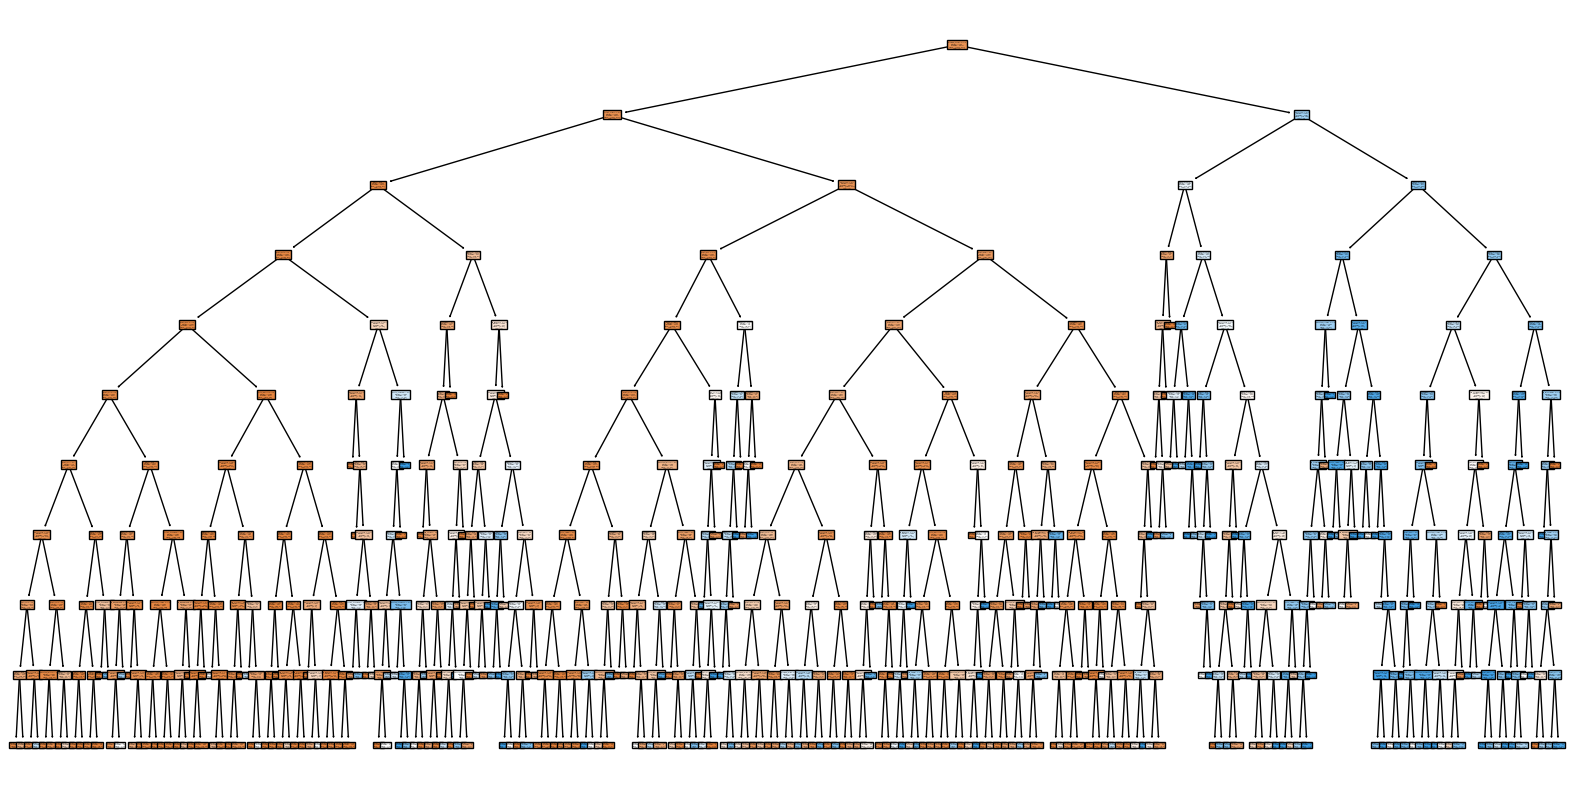

In [ ]:
from sklearn import tree

plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
tree.plot_tree(dt, filled=True, feature_names=X.columns, class_names=["No", "Yes"])

# Save the plot as a high-quality image
plt.savefig('decision_tree_plot.png', dpi=300, bbox_inches='tight')

# Random Forest Classifier



1. No hyper parameters. No balanced

In [ ]:
X = df.drop(["y", "duration"], axis = 1) #drop duration column as this affect our model and is only used for benchmark (based on documentation)
y = df['y']
print(X.shape)
print(y.shape)
# Initialize Random Forest classifier
rf = RandomForestClassifier()

#splitting data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Fitting data and model
rf.fit(X_train, y_train)
# forecasting with model
pred = rf.predict(X_test)
#preducting probability of forecast outcome
pred_probability = rf.predict_proba(X_test)




(45211, 46)
(45211,)


Evaluation of Random Forrest Classifier

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
cm = confusion_matrix(y_test, pred)
print('CONFUSION MATRIX')
print(cm)

accuracy_score = accuracy_score(y_test, pred)
print('ACCURACY SCORE: ',accuracy_score)

classification_report = classification_report(y_test, pred)
print('CLASSIFICATION REPORT')
print(classification_report)

CONFUSION MATRIX
[[7803  149]
 [ 833  258]]
ACCURACY SCORE:  0.8914077186774301
CLASSIFICATION REPORT
              precision    recall  f1-score   support

       False       0.90      0.98      0.94      7952
        True       0.63      0.24      0.34      1091

    accuracy                           0.89      9043
   macro avg       0.77      0.61      0.64      9043
weighted avg       0.87      0.89      0.87      9043



We can appreciate that the accuracy is high 0.89, however from the confusion matrix is possible to see that there are many  false negative values.

In [ ]:
y_train.value_counts()

y
False    31970
True      4198
Name: count, dtype: int64

Random forrest seems to have performed quite well. However the target variable distrubution is strongly unbalanced. There are a lot more 'no' for marketing We will attempt to even out the data in attempt to increase the models performance and limit bias

 2. No hyper parameters. ***BALANCED***

In [ ]:
# Calculate class weights
total_samples = df["y"].value_counts().sum()
# Initialize Random Forest classifier with class weights
rf_weighted = RandomForestClassifier(class_weight='balanced')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
# Fit the classifier to your training data
rf_weighted.fit(X_train, y_train)
# forecasting with model
pred = rf_weighted.predict(X_test)
#preducting probability of forecast outcome
pred_probability = rf_weighted.predict_proba(X_test)

#EVALUATION OF MODEL
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
cm = confusion_matrix(y_test, pred)
print('CONFUSION MATRIX')
print(cm)

accuracy = accuracy_score(y_test, pred)
print('ACCURACY SCORE: ',accuracy)

class_report = classification_report(y_test, pred)
print('CLASSIFICATION REPORT')
print(class_report)

CONFUSION MATRIX
[[7832  120]
 [ 851  240]]
ACCURACY SCORE:  0.8926241291606768
CLASSIFICATION REPORT
              precision    recall  f1-score   support

       False       0.90      0.98      0.94      7952
        True       0.67      0.22      0.33      1091

    accuracy                           0.89      9043
   macro avg       0.78      0.60      0.64      9043
weighted avg       0.87      0.89      0.87      9043



Adding weights to the model slightly increased the precision of for the prediction of the 'yes' target which was originally undersampled. The confusion matrix shows no significant improvement.

3.  Hyper parameters. **Stratified**

In order to increase the models predictive powers and better its accuracy, we decided to try undersampling inorder to balance out the data. this way we have an even representation of successes and failures in the data. This comes at the cost of training the model with a lot less data. Also, we used stratified sampling to make sure that also after splitting the data into training and testing, we still have an even y distribution.

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
# Separate majority and minority classes
df_majority = df[df['y'] == False]
df_minority = df[df['y'] == True]

# Sample the majority class to match the size of the minority class
df_majority_sampled = df_majority.sample(n=len(df_minority), random_state=42)

# Concatenate the sampled majority class with the minority class
df_balanced = pd.concat([df_majority_sampled, df_minority])

# Shuffle the dataframe to mix the samples
#df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Initialize Random Forest classifier with class weights
rf_balanced = RandomForestClassifier(class_weight='balanced')

X = df_balanced.drop(["y", "duration"], axis = 1)
y = df_balanced['y']

# Split the dataset into training and testing sets. Stratified sampling for balanced y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)

# Fit the classifier to your training data
rf_balanced.fit(X_train, y_train)

# Forecasting with the model
y_pred = rf_balanced.predict(X_test)

# Predicting probability of forecast outcome
y_pred_proba = rf_balanced.predict_proba(X_test)

# Evaluation of model
print('CONFUSION MATRIX')
cm = confusion_matrix(y_test, y_pred)
print(cm)

accuracy = accuracy_score(y_test, y_pred)
print('ACCURACY SCORE:', accuracy)

classification_report_str = classification_report(y_test, y_pred)
print('CLASSIFICATION REPORT')
print(classification_report_str)


CONFUSION MATRIX
[[825 233]
 [359 699]]
ACCURACY SCORE: 0.720226843100189
CLASSIFICATION REPORT
              precision    recall  f1-score   support

       False       0.70      0.78      0.74      1058
        True       0.75      0.66      0.70      1058

    accuracy                           0.72      2116
   macro avg       0.72      0.72      0.72      2116
weighted avg       0.72      0.72      0.72      2116



accuracy has decreased and the confusion matrix changed

Text(0.5, 1.0, 'Confusion Matrix')

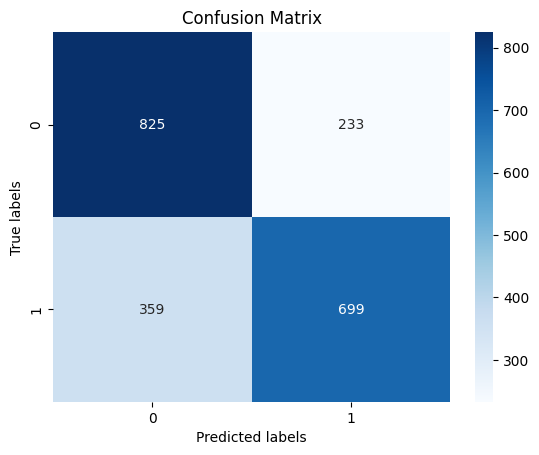

In [ ]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Show the plot

    We now undersampled the unbalanced target variable in an attempt to gain better model performance.
    This did lead to less false positves however we still cannot see a significant imrovement.

# Feature Importance Extraction

In [ ]:

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame to hold feature names and importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance values in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the sorted DataFrame
print(feature_importance_df)

                Feature  Importance
1               balance    0.170787
0                   age    0.146626
2           day_of_week    0.122762
3              campaign    0.061052
49     poutcome_success    0.051380
4                 pdays    0.047022
5              previous    0.025738
22  education_secondary    0.014942
28          housing_yes    0.014436
15       job_technician    0.013932
34            month_apr    0.013739
23   education_tertiary    0.013659
27           housing_no    0.013187
10       job_management    0.012586
19      marital_married    0.012334
41            month_mar    0.012265
6            job_admin.    0.011597
20       marital_single    0.011252
40            month_jun    0.011220
7       job_blue-collar    0.011019
44            month_oct    0.010886
35            month_aug    0.010164
42            month_may    0.009919
39            month_jul    0.009624
33      contact_unknown    0.009604
31     contact_cellular    0.009405
21    education_primary    0

As there are quite a few features with low importance scores, below 0.01, we will exclude those features in the next attempt to imporve the random forrest classifiers performance, using the undersampled balanced data.

In [ ]:
#features with importance scores below 0.01
low_importance_features = feature_importance_df[feature_importance_df['Importance'] < 0.01]['Feature'].tolist()

print("Features with importance scores below 0.01:")
print(low_importance_features)


Features with importance scores below 0.01:
['month_may', 'month_jul', 'contact_unknown', 'contact_cellular', 'education_primary', 'job_services', 'month_feb', 'month_sep', 'marital_divorced', 'poutcome_failure', 'month_nov', 'poutcome_ongoing', 'loan_no', 'loan_yes', 'job_self-employed', 'job_retired', 'education_unknown', 'job_unemployed', 'month_jan', 'contact_telephone', 'job_student', 'job_entrepreneur', 'poutcome_other', 'month_dec', 'job_housemaid', 'default_no', 'default_yes', 'job_unknown']


4. Most important features and Balanced data

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


# Initialize Random Forest classifier with class weights
rf= RandomForestClassifier(class_weight='balanced')

X = df.drop(low_importance_features, axis = 1)
X = X.drop(["y"], axis = 1) #drop duration if there

#X = X.drop(low_importance_features, axis = 1)
y = df['y']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)

# Fit the classifier to your training data
rf.fit(X_train, y_train)

# Forecasting with the model
y_pred = rf.predict(X_test)

# Predicting probability of forecast outcome
y_pred_proba = rf.predict_proba(X_test)

# Evaluation of model
print('CONFUSION MATRIX')
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy = accuracy_score(y_test, y_pred)
print('ACCURACY SCORE:', accuracy)

classification_report_str = classification_report(y_test, y_pred)
print('CLASSIFICATION REPORT')
print(classification_report_str)


CONFUSION MATRIX
[[7825  160]
 [ 719  339]]
ACCURACY SCORE: 0.9027977441114674
CLASSIFICATION REPORT
              precision    recall  f1-score   support

       False       0.92      0.98      0.95      7985
        True       0.68      0.32      0.44      1058

    accuracy                           0.90      9043
   macro avg       0.80      0.65      0.69      9043
weighted avg       0.89      0.90      0.89      9043



Too high number of false positives and false negatices. removing the seeminly low importance features lead to a worse performance.

Text(0.5, 1.0, 'Confusion Matrix')

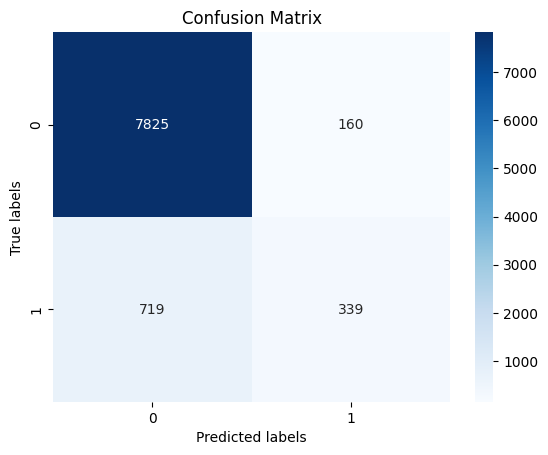

In [ ]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

too high false positive.

BONUS RECOMMENDATION ALGORITHM
There are mainly two types of recommender engines. We will be focusing on beeing able to offer customers tailored marketing strategies based on customer similarities, also known as collaborative filtering.


how am i supposed to recommend a certain marketing strategy? we dont have data on that. all i can do is group the customers segments based on similarities.

5. Grid search for random forest

In [ ]:
#best param by gridsearch
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


# Initialize Random Forest classifier with class weights
rf = RandomForestClassifier(max_depth=None, max_features='log2', min_samples_leaf=1, min_samples_split=5, n_estimators=300)

X = df.drop(low_importance_features, axis = 1)
X = X.drop(["y"], axis = 1) #drop duration if there

#X = X.drop(low_importance_features, axis = 1)
y = df['y']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)

# Fit the classifier to your training data
rf.fit(X_train, y_train)

# Forecasting with the model
y_pred = rf.predict(X_test)

# Predicting probability of forecast outcome
y_pred_proba = rf.predict_proba(X_test)

# Evaluation of model
print('CONFUSION MATRIX')
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy = accuracy_score(y_test, y_pred)
print('ACCURACY SCORE:', accuracy)

classification_report_str = classification_report(y_test, y_pred)
print('CLASSIFICATION REPORT')
print(classification_report_str)


In [ ]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

#SVM method

1. With grid search (NO RESULTS YET) UPDATE CODE FROM NOTEBOOK

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC

# X = df.drop(low_importance_features, axis = 1)#keep only high importance features
# X = X.drop(["y"], axis = 1) #drop duration if there

# #X = X.drop(low_importance_features, axis = 1)
# y = df['y']

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)

# param_grid = {
#     'C': [0.1, 1, 10, 100],  # Regularization parameter
#     'kernel': ['linear', 'rbf'],  # Type of kernel function
#     'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf'
#     'probability': [True, False],  # Whether to enable probability estimates
#     'class_weight': ['balanced'],  # Adjust weights inversely proportional to class frequencies
#     'decision_function_shape': ['ovr']  # Decision function shape: one-vs-rest (ovr) or one-vs-one (ovo)
# }


# svm_class = SVC()
# svm_class.fit(X_train, y_train)
# y_pred = svm_class.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)


# svm_cv = GridSearchCV(svm_class, param_grid, cv=5)
# svm_cv.fit(X_train, y_train)
# y_pred = svm_cv.predict(X_test)

# # EVALUATION

# print("Tuned SVM classification Parameters: {}".format(svm_cv.best_params_))
# print("Best score is {}".format(svm_cv.best_score_))

# mean_scores = svm_cv.cv_results_['mean_test_score']

# # Plotting
# plt.figure(figsize=(10, 6))
# #plt.semilogx(c_space, mean_scores, marker='o', color='b', linestyle='-')
# plt.semilogx(svm_cv.best_params_['C'], svm_cv.best_score_, marker='x', markersize=15, color='r', label='Best parameter')
# plt.xlabel('C (Regularization parameter)')
# plt.ylabel('CV Average Score')
# plt.title('SVM Classification Performance')
# plt.legend()
# plt.grid(True)
# plt.show()

# Neural Network

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split



# Generate sample data
X = df.drop(low_importance_features, axis = 1)
X = X.drop(["y"], axis = 1) #drop duration if there is

#X = X.drop(low_importance_features, axis = 1)
y = df['y']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)
X_train = X_train.astype('int')
X_test = X_test.astype('int')
# Define the model architecture
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(23,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

NameError: name 'low_importance_features' is not defined